In [1]:
# Preamble
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

import mct

# Load and Explore the Sample Data

TODO: describe the sample data and include generation script

In [2]:
df_raw = pd.read_pickle('sample_classification_results.pkl')
actual = df_raw.actual.copy()
preds = df_raw.xs('Prediction', level='Method', axis=1)
probs = df_raw.xs('Probability', level='Method', axis=1)
probs.head()

Classifier,LogisticRegression,GaussianNB,LinearSVC,RandomForestClassifier,SGDClassifier,KNeighborsClassifier
0,0.979908,1.0,0.627873,1.0,0.626272,1.0
1,0.968832,1.0,0.574250,1.0,0.631219,1.0
2,0.972728,1.0,0.578030,1.0,0.629980,1.0
3,0.999986,1.0,0.775335,1.0,0.747994,1.0
4,0.815760,1.0,0.574944,1.0,0.549328,1.0


In [3]:
# Display some basic scoring and summary data about the classifiers
from sklearn.metrics import (precision_recall_curve, brier_score_loss,
                             accuracy_score, precision_score, recall_score, f1_score,
                             average_precision_score, roc_curve, auc,
                             confusion_matrix)

from functools import partial

pre = preds.agg(partial(precision_score, actual))
rec = preds.agg(partial(recall_score, actual))
acc = preds.agg(partial(accuracy_score, actual))
f_1 = preds.agg(partial(f1_score, actual))
brier = probs.agg(partial(brier_score_loss, actual))
total = preds.agg(sum)

stats = pd.DataFrame([total, acc, pre, rec, f_1, brier], 
                     index=('Total', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Brier'))
stats

Classifier,LogisticRegression,GaussianNB,LinearSVC,RandomForestClassifier,SGDClassifier,KNeighborsClassifier
Total,4961.000000,5476.000000,5159.000000,4857.000000,4339.000000,4872.000000
Accuracy,0.899500,0.800400,0.854300,0.970700,0.860700,0.985200
Precision,0.895182,0.767531,0.836209,0.976940,0.907121,0.990353
Recall,0.901543,0.853228,0.875761,0.963256,0.799026,0.979497
F1 Score,0.898351,0.808114,0.855528,0.970050,0.849649,0.984895
Brier,0.074896,0.195931,0.194744,0.030084,0.174904,0.012256


## Calibration Histograms

In [4]:
# Brier Score Losses & sort Probs by brier score loss
conf_mats = np.array([confusion_matrix(actual, p).ravel()
                      for _, p in preds.iteritems()])
confusion = pd.DataFrame(conf_mats, 
                         index=preds.columns, 
                         columns=('TN', 'FP', 'FN', 'TP'))
confusion = confusion.assign(brier_score=brier)
confusion.sort_values(by='brier_score', inplace=True)
print(confusion)

probs = probs.reindex(confusion.index, axis=1)

                          TN    FP   FN    TP  brier_score
Classifier                                                
KNeighborsClassifier    5027    47  101  4825     0.012256
RandomForestClassifier  4962   112  181  4745     0.030084
LogisticRegression      4554   520  485  4441     0.074896
SGDClassifier           4671   403  990  3936     0.174904
LinearSVC               4229   845  612  4314     0.194744
GaussianNB              3801  1273  723  4203     0.195931


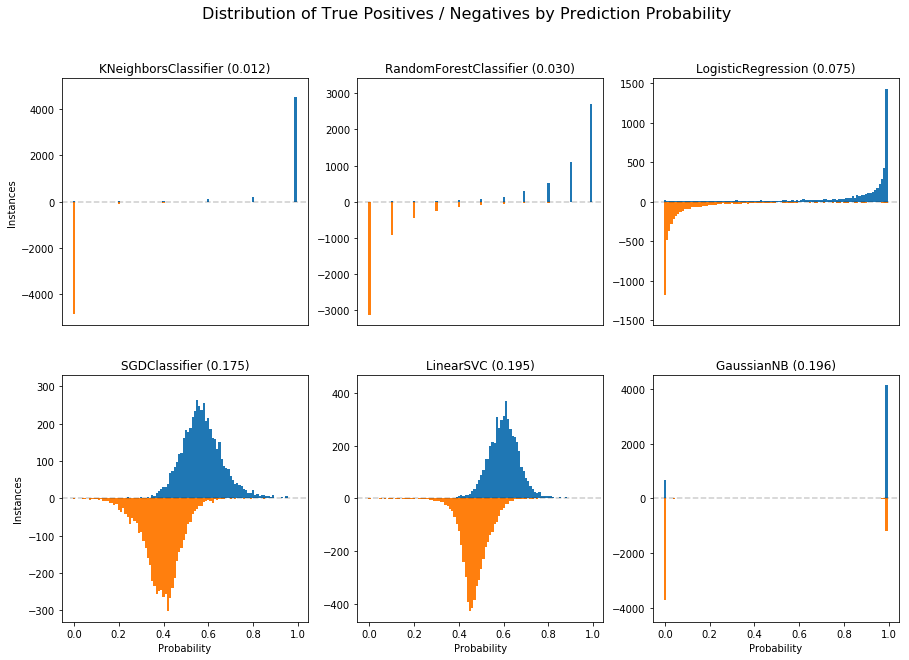

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(15, 10))
axes = axes.ravel()

for ax, (label, prob_vec) in zip(axes, probs.iteritems()):
    brier = confusion.brier_score[label]
    ax = mct.draw_histograms(prob_vec, actual, ax=ax)
    ax.set_title(f'{label} ({brier:.3f})')
    
fig.suptitle('Distribution of True Positives / Negatives by Prediction Probability', fontsize=16)

# Left Side labels
axes[0].set_ylabel('Instances')
axes[3].set_ylabel('Instances')

# Bottom labels
axes[3].set_xlabel('Probability')
axes[4].set_xlabel('Probability')
axes[5].set_xlabel('Probability')
    
# Remove extra ticks
axes[0].xaxis.set_ticks_position('none')
axes[1].xaxis.set_ticks_position('none')
axes[2].xaxis.set_ticks_position('none')

plt.show()

### Calibration Curves w/ KDE Smoothing

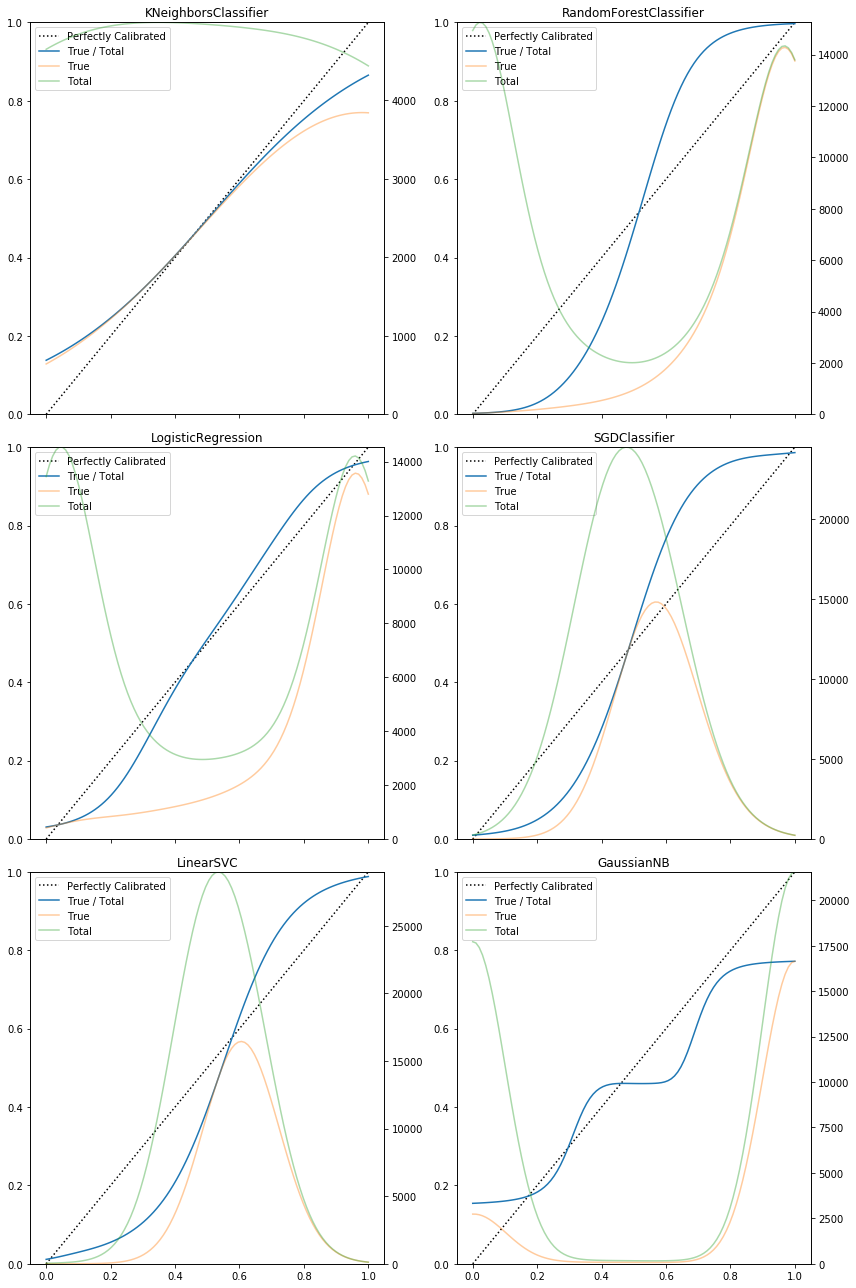

In [6]:
unit = (0, 1)
x_axis = np.linspace(0, 1, 100)
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(12, 18))
axes = axes.ravel()

def plot_kde_curve(curve, true, total, label, ax):
    ax.set_ylim(unit)
    ax.set_ylim(unit)
    ax2 = ax.twinx()
    ax2.set_ylim((0, total.max()))

    lines = []
    lines.extend(ax.plot(unit, unit, 'k:', label='Perfectly Calibrated'))
    lines.extend(ax.plot(x_axis, curve, label='True / Total'))
    lines.extend(ax2.plot(x_axis, true, 'C1', alpha=0.4, label='True'))
    lines.extend(ax2.plot(x_axis, total, 'C2', alpha=0.4, label='Total'))         
    ax.legend(lines, [li.get_label() for li in lines], loc='best')
    ax.set_title(f'{label}')
    return ax

for ax, (label, prob_vec) in zip(axes, probs.iteritems()):
    bandwidth = 0.5 if label == 'KNeighborsClassifier' else 0.1
    curve, true, total = mct.kde_calibration_curve(prob_vec.values, 
                                                   actual.values,
                                                   bandwidth=bandwidth,
                                                   retraw=True)
    ax = plot_kde_curve(curve, true, total, label, ax)
    
plt.tight_layout()
plt.show()